# Install and Import Required Libraries

In [3]:
!pip install lime

In [2]:
!pip install wordcloud

In [4]:
!pip install shap

In [5]:
!pip install scikeras

In [6]:
!pip install tensorflow

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, BatchNormalization, GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

import shap
from wordcloud import WordCloud
import lime
from lime.lime_text import LimeTextExplainer
import time
from datetime import timedelta

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv('C:\\Users\\haldo\\Documents\\Dropbox\\2023 to 2025 - Lambton College\\T3. TERM 03, MAY-AGO 2024\\06, Fri02, 2024S-T3 AML 2304 - Natural Language Processing\\x FINAL PROJECT\\Data\\sentiment_and_topics.csv')

In [ ]:
df

In [10]:
print(df['cleaned_text'].dtype)
print(df['cleaned_text'].isnull().sum())

object
50


In [11]:
df['cleaned_text'] = df['cleaned_text'].astype(str).replace('nan', '')

In [12]:
# Prepare the text data
text_data = df['cleaned_text'].values  # or 'custom_tokens' if it's already tokenized
max_words = 10000
max_len = 200

In [13]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_data)
X_text = tokenizer.texts_to_sequences(text_data)
X_text_pad = pad_sequences(X_text, maxlen=max_len)

In [50]:
text_data

array(['This One can make an analogy in mathematical terms by envisioning the distribution of opinions in a population as a Gaussian curve Be would then say that the consensus would be a statement that represents the range of opinions within perhaps three standard deviations of the mean opinion sounds arbitrary and and how Does it really belong in a encyclopedia article I done see that it adds anything useful The paragraph that follows seems much more useful Are there any political theorists out there who can clarify the issues It seems to me that this is an issue that Locke Rousseau de Tocqueville and others must have debated SR',
       'Clarification for you and Zundarks right i should have checked the Wikipedia bugs page first This is a bug in the code that makes wikipedia work it just means that there is a line of code that may have an error as small as an extra space Its analogous in a allcaps VERY allcaps simplified way to trying to make something bold in allcaps HTML allcaps an

In [19]:
import json
import pickle

# Save tokenizer configuration
tokenizer_config = tokenizer.to_json()
with open('../saved_models/tokenizer_config.json', 'w') as json_file:
    json.dump(tokenizer_config, json_file)

# tokenizer_weights = tokenizer.get_weights()
# with open('tokenizer_weights.pkl', 'wb') as pkl_file:
#     pickle.dump(tokenizer_weights, pkl_file)

In [24]:
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# Load tokenizer configuration
with open('../saved_models/tokenizer_config.json') as json_file:
    tokenizer_config = json.load(json_file)
tokenizer = tokenizer_from_json(tokenizer_config)

# # Load tokenizer weights
# with open('tokenizer_weights.pkl', 'rb') as pkl_file:
#     tokenizer_weights = pickle.load(pkl_file)
# tokenizer.set_weights(tokenizer_weights)

In [21]:
# Prepare additional features
additional_features = df[['sentiment_polarity', 'sentiment_subjectivity', 'dominant_topic']].values

# Normalize additional features
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

In [49]:
additional_features

array([[9.86111111e-02, 2.31944444e-01, 9.00000000e+00],
       [1.85714286e-01, 4.58630952e-01, 6.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.00000000e+00],
       ...,
       [3.70370370e-03, 4.85185185e-01, 2.00000000e+00],
       [1.50000000e-01, 5.30555556e-01, 2.00000000e+00],
       [9.00000000e-02, 3.30000000e-01, 6.00000000e+00]])

In [52]:
import pickle

with open('../saved_models/scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)


<Figure size 1500x800 with 0 Axes>

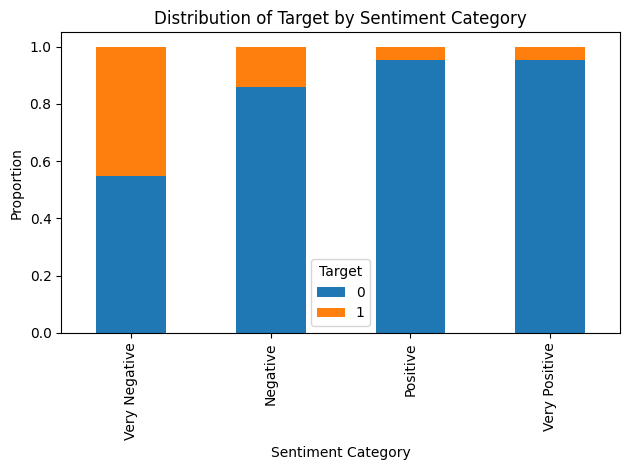

<Figure size 1200x600 with 0 Axes>

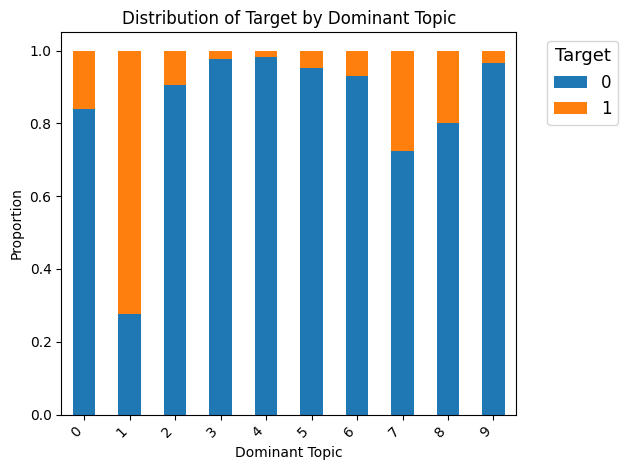

<Figure size 640x480 with 0 Axes>

In [30]:
# Set up the plot style
#plt.style.use('seaborn')

# 1. Stacked bar chart for target and sentiment
plt.figure(figsize=(15, 8))
df['sentiment_category'] = pd.cut(df['sentiment_polarity'],
                                  bins=[-1, -0.5, 0, 0.5, 1],
                                  labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])
sentiment_target = pd.crosstab(df['sentiment_category'], df['oh_label'], normalize='index')
sentiment_target.plot(kind='bar', stacked=True)
plt.title('Distribution of Target by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Proportion')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

# 2. Stacked bar chart for dominant topic and target
plt.figure(figsize=(12, 6))
topic_target = pd.crosstab(df['dominant_topic'], df['oh_label'], normalize='index')
topic_target.plot(kind='bar', stacked=True)
plt.title('Distribution of Target by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Proportion')
plt.legend(title='Target', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

## Split data and define Target Variable

In [31]:
# define target variable
y = df['oh_label'].values

# Split the data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text_pad, additional_features_scaled, y, test_size=0.2, random_state=42, stratify=y
)


# The first Model based on Only TEXT data

In [32]:
# Build the first model
embedding_dim = 100

model_1 = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(name='auc')])

# Compute class weights
class_weights = None
if len(np.unique(y_train)) == 2:  # Binary classification
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
else:
    print("Not using class weights (multiclass problem or already balanced)")

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_model_1.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Record start time
start_time = time.time()

# Train the model
history = model_1.fit(
    X_text_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict if class_weights is not None else None,
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time

# Load the best model
model_1.load_weights('best_model_1.h5')

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime)}")

Epoch 1/50
3194/3194 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8850 - auc: 0.9432
Epoch 1: val_auc improved from -inf to 0.96948, saving model to best_model_1.h5
3194/3194 [==============================] - 529s 164ms/step - loss: 0.3005 - accuracy: 0.8850 - auc: 0.9432 - val_loss: 0.2091 - val_accuracy: 0.9294 - val_auc: 0.9695
Epoch 2/50


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


3194/3194 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9181 - auc: 0.9738
Epoch 2: val_auc improved from 0.96948 to 0.97011, saving model to best_model_1.h5
3194/3194 [==============================] - 494s 155ms/step - loss: 0.2055 - accuracy: 0.9181 - auc: 0.9738 - val_loss: 0.2309 - val_accuracy: 0.9148 - val_auc: 0.9701
Epoch 3/50
3194/3194 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9333 - auc: 0.9844
Epoch 3: val_auc did not improve from 0.97011
3194/3194 [==============================] - 632s 198ms/step - loss: 0.1553 - accuracy: 0.9333 - auc: 0.9844 - val_loss: 0.1988 - val_accuracy: 0.9115 - val_auc: 0.9649
Epoch 4/50
3194/3194 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9455 - auc: 0.9900
Epoch 4: val_auc did not improve from 0.97011
3194/3194 [==============================] - 588s 184ms/step - loss: 0.1186 - accuracy: 0.9455 - auc: 0.9900 - val_loss: 0.1670 - val_accuracy: 0.9353 - val_auc: 

## Evaluate the First Model

In [33]:
# Load the best model
model_1.load_weights('best_model_1.h5')

# Evaluate the model
y_pred = model_1.predict(X_text_test)
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc_score}")

999/999 [==============================] - 54s 52ms/step
Test AUC: 0.9707542547532853


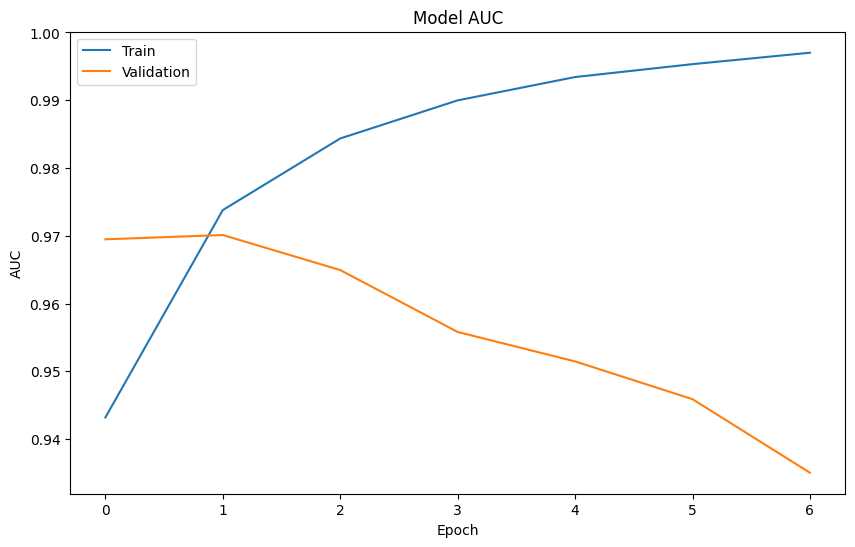

In [34]:
# Plot AUC over epochs

plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model interpretability

In [51]:
instance

'I read lot of comments in the net about if the movie or the novel is better I think they both quite good Movie and novel are quite different mediums To it is NEG_not quite possible to compare both I personally find the last capital of the novel quite disappointing and somehow unnecessary Landings marriage and his conversion to christians is for me a double betrayal against Any'

In [35]:
# Define a function to preprocess text data
def preprocess_text(instance):
    # Tokenize and pad the instance
    instance_seq = tokenizer.texts_to_sequences([instance])
    instance_pad = pad_sequences(instance_seq, maxlen=max_len)
    return instance_pad

# Define a prediction function wrapper for LIME
def predict_with_preprocessing(texts):
    texts_prep = np.array([preprocess_text(text) for text in texts])
    texts_prep = texts_prep.squeeze()  # Remove extra dimension
    predictions = model_1.predict(texts_prep)
    return np.hstack((1 - predictions, predictions))  # Adjust shape for LIME

# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

# Explain a single instance
idx = 0  # index of the instance to explain
instance = df['cleaned_text'][idx]
exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)

# Show explanation
exp.show_in_notebook(text=instance)


157/157 [==============================] - 7s 44ms/step


In [36]:
# Explain a single instance
idx = 100  # index of the instance to explain (change index to see different example)
instance = df['cleaned_text'][idx]
exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)

# Show explanation
exp.show_in_notebook(text=instance)

157/157 [==============================] - 8s 50ms/step


In [37]:
# Explain a single instance
idx = 22  # index of the instance to explain (change index to see different example)
instance = df['cleaned_text'][idx]
exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)

# Show explanation
exp.show_in_notebook(text=instance)

157/157 [==============================] - 7s 44ms/step


In [38]:
# Explain a single instance
idx = 333  # index of the instance to explain (change index to see different example)
instance = df['cleaned_text'][idx]
exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)

# Show explanation
exp.show_in_notebook(text=instance)

157/157 [==============================] - 7s 44ms/step


In [39]:
from tensorflow.keras.models import load_model

# Save model
model_1.save('../saved_models/model_01.h5')

# Load model
model_1 = load_model('../saved_models/model_01.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


# The Second Model:

We've kept the two LSTM layers from the original Sequential model in the text input branch.
We've added an additional features input branch, which takes in the scaled additional features.
The outputs of both branches are concatenated before being passed through the final dense layers.
We're using the functional API of Keras (with Model instead of Sequential) to handle multiple inputs.

It's setting up a more complex model that combines text input (processed through embedding and LSTM layers) with additional numerical features. Here's a breakdown of what the code is doing:

It defines the model architecture:

Text input branch with embedding and LSTM layers
Additional features input branch with a dense layer
Concatenation of both branches
Final dense layers for classification


It compiles the model with appropriate optimizer, loss function, and metric.
It sets up callbacks for early stopping and model checkpointing.
It trains the model with the specified parameters and records the training time.


The increased number of epochs (50) combined with early stopping is a good approach to allow the model to train longer if needed while preventing overfitting.

The use of class weights is good for handling imbalanced datasets.

In [21]:
# Build the second model
embedding_dim = 100

# defining the layers:

# Text input branch
text_input = Input(shape=(max_len,))
embedding = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm1 = LSTM(64, return_sequences=True)(embedding)
lstm2 = LSTM(32)(lstm1)

# Additional features input branch
feature_input = Input(shape=(additional_features_scaled.shape[1],))
feature_dense = Dense(32, activation='relu')(feature_input)

# Concatenate both branches
concatenated = Concatenate()([lstm2, feature_dense])
dense1 = Dense(64, activation='relu')(concatenated)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation='sigmoid')(dropout)

# Create the model
model_2 = Model(inputs=[text_input, feature_input], outputs=output)

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Record start time
start_time = time.time()

# Train the model
history2 = model_2.fit(
    [X_text_train, X_feat_train], y_train,
    validation_split=0.2,
    epochs=50,  # Increased epochs, early stopping will prevent overfitting
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime)}")



Epoch 1/50
3193/3194 [============================>.] - ETA: 0s - loss: 0.2980 - auc: 0.9444
Epoch 1: val_auc improved from -inf to 0.96604, saving model to best_model.h5
3194/3194 [==============================] - 113s 34ms/step - loss: 0.2980 - auc: 0.9444 - val_loss: 0.1870 - val_auc: 0.9660
Epoch 2/50
   3/3194 [..............................] - ETA: 1:26 - loss: 0.1936 - auc: 0.9860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3193/3194 [============================>.] - ETA: 0s - loss: 0.2016 - auc: 0.9744
Epoch 2: val_auc improved from 0.96604 to 0.96883, saving model to best_model.h5
3194/3194 [==============================] - 65s 20ms/step - loss: 0.2016 - auc: 0.9745 - val_loss: 0.2005 - val_auc: 0.9688
Epoch 3/50
3192/3194 [============================>.] - ETA: 0s - loss: 0.1623 - auc: 0.9832
Epoch 3: val_auc did not improve from 0.96883
3194/3194 [==============================] - 68s 21ms/step - loss: 0.1623 - auc: 0.9832 - val_loss: 0.1848 - val_auc: 0.9662
Epoch 4/50
3193/3194 [============================>.] - ETA: 0s - loss: 0.1320 - auc: 0.9883
Epoch 4: val_auc did not improve from 0.96883
3194/3194 [==============================] - 61s 19ms/step - loss: 0.1320 - auc: 0.9883 - val_loss: 0.2198 - val_auc: 0.9634
Epoch 5/50
3193/3194 [============================>.] - ETA: 0s - loss: 0.1077 - auc: 0.9917
Epoch 5: val_auc did not improve from 0.96883
3194/3194 [==============================] - 

In [22]:
# Evaluate the model
y_pred = model_2.predict([X_text_test, X_feat_test])
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc_score}")

999/999 [==============================] - 7s 6ms/step
Test AUC: 0.9581111771490104


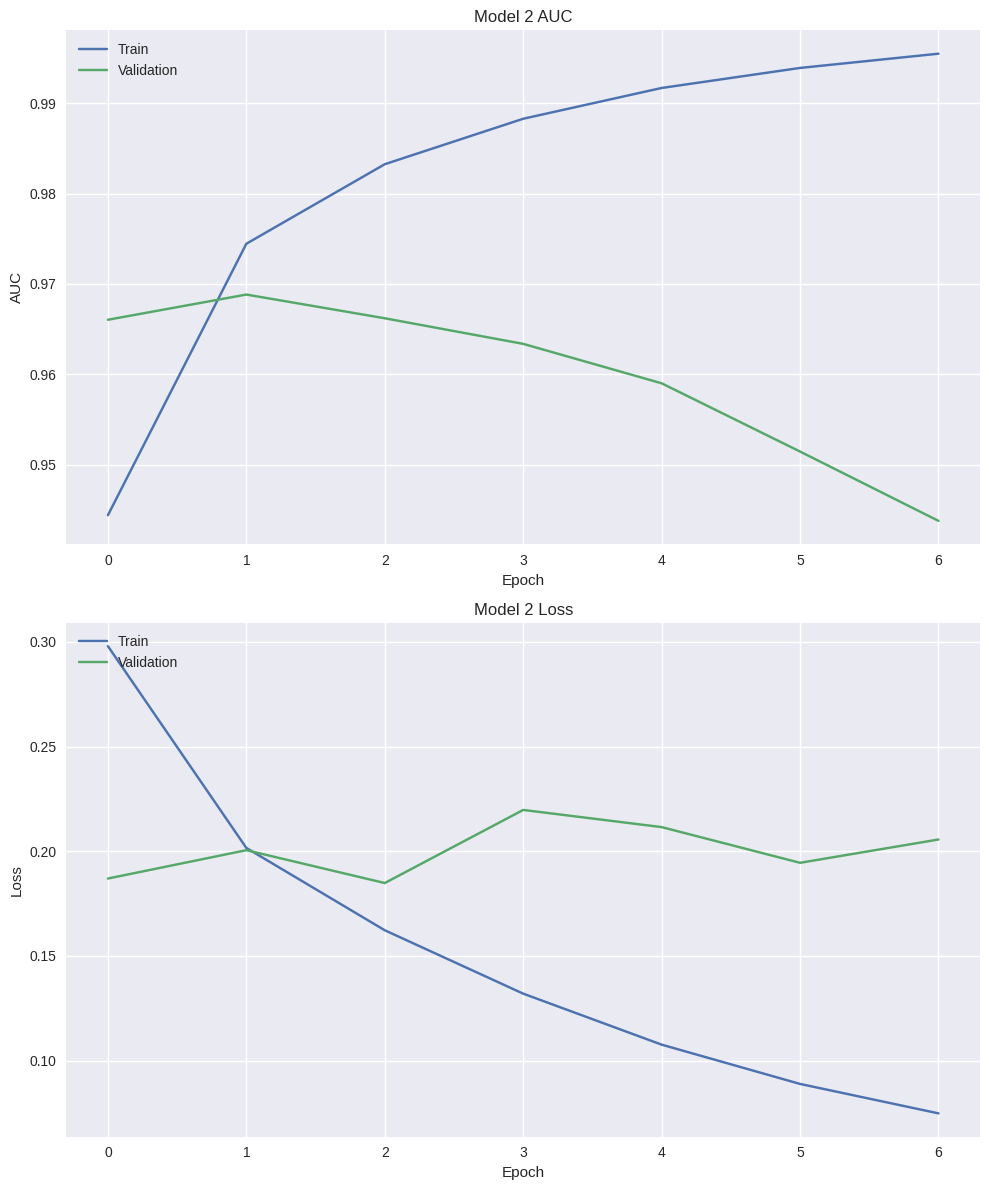

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot AUC
ax1.plot(history2.history['auc'])
ax1.plot(history2.history['val_auc'])
ax1.set_title('Model 2 AUC')
ax1.set_ylabel('AUC')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('Model 2 Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

This graph shows the Area Under the Curve (AUC) performance of Model 2 over training epochs for both the training and validation datasets. Here's an analysis of the plot:

Training Performance (Blue Line):

The training AUC starts around 0.945 and rapidly improves.
It shows consistent improvement over epochs, reaching above 0.99 by the end.
This indicates the model is learning well on the training data.


Validation Performance (Orange Line):

The validation AUC starts high (about 0.97) but then decreases over time.
It peaks around epoch 1 and then consistently declines.
By epoch 6, it has dropped to about 0.945.


Overfitting:

The divergence between training and validation performance is a clear sign of overfitting.
The model is memorizing the training data but not generalizing well to new data.


Early Stopping:

The best validation performance is around epoch 1-2.
Early stopping would likely have halted training at this point to prevent overfitting.


Model Adjustments Needed:

To address overfitting, consider:

Increasing regularization ( more dropout, L2 regularization)
Reducing model complexity
Gathering more training data
Using data augmentation techniques




Training Duration:

The graph shows 6 epochs, which is relatively few. The early stopping mechanism likely kicked in due to declining validation performance.

# The Third Model using Model Tuning

In [40]:
# the Third Model

embedding_dim = 50
text_input = Input(shape=(max_len,))

embedding = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm1 = LSTM(32, return_sequences=True)(embedding)
lstm2 = LSTM(16)(lstm1)
batch_norm1 = BatchNormalization()(lstm2)

feature_input = Input(shape=(additional_features_scaled.shape[1],))
feature_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(feature_input)

concatenated = Concatenate()([batch_norm1, feature_dense])
dense1 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation='sigmoid')(dropout)

model_3 = Model(inputs=[text_input, feature_input], outputs=output)
model_3.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', verbose=1, restore_best_weights=True)
#Implement a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


# Record start time
start_time = time.time()

# Train the model
history3 = model_3.fit(
    [X_text_train, X_feat_train], y_train,
    validation_split=0.2,
    epochs=50,  # Increased epochs, early stopping will prevent overfitting
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime)}")

Epoch 1/50
3194/3194 [==============================] - 409s 121ms/step - loss: 0.3681 - auc: 0.9357 - val_loss: 0.1530 - val_auc: 0.9652 - lr: 0.0010
Epoch 2/50
3194/3194 [==============================] - 338s 106ms/step - loss: 0.2278 - auc: 0.9698 - val_loss: 0.1345 - val_auc: 0.9683 - lr: 0.0010
Epoch 3/50
3194/3194 [==============================] - 334s 105ms/step - loss: 0.1802 - auc: 0.9804 - val_loss: 0.1955 - val_auc: 0.9665 - lr: 0.0010
Epoch 4/50
3194/3194 [==============================] - 349s 109ms/step - loss: 0.1459 - auc: 0.9865 - val_loss: 0.2867 - val_auc: 0.9628 - lr: 0.0010
Epoch 5/50
3194/3194 [==============================] - 454s 142ms/step - loss: 0.1019 - auc: 0.9928 - val_loss: 0.1830 - val_auc: 0.9559 - lr: 2.0000e-04
Epoch 6/50
3194/3194 [==============================] - 363s 114ms/step - loss: 0.0848 - auc: 0.9945 - val_loss: 0.2328 - val_auc: 0.9526 - lr: 2.0000e-04
Epoch 7/50
3194/3194 [==============================] - 388s 121ms/step - loss: 0.0726

In [55]:
len(X_text_test)

31938

In [56]:
len(X_feat_test)

31938

In [41]:
# Evaluate the model
y_pred = model_3.predict([X_text_test, X_feat_test])
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc_score}")

999/999 [==============================] - 30s 28ms/step
Test AUC: 0.9692613651946349


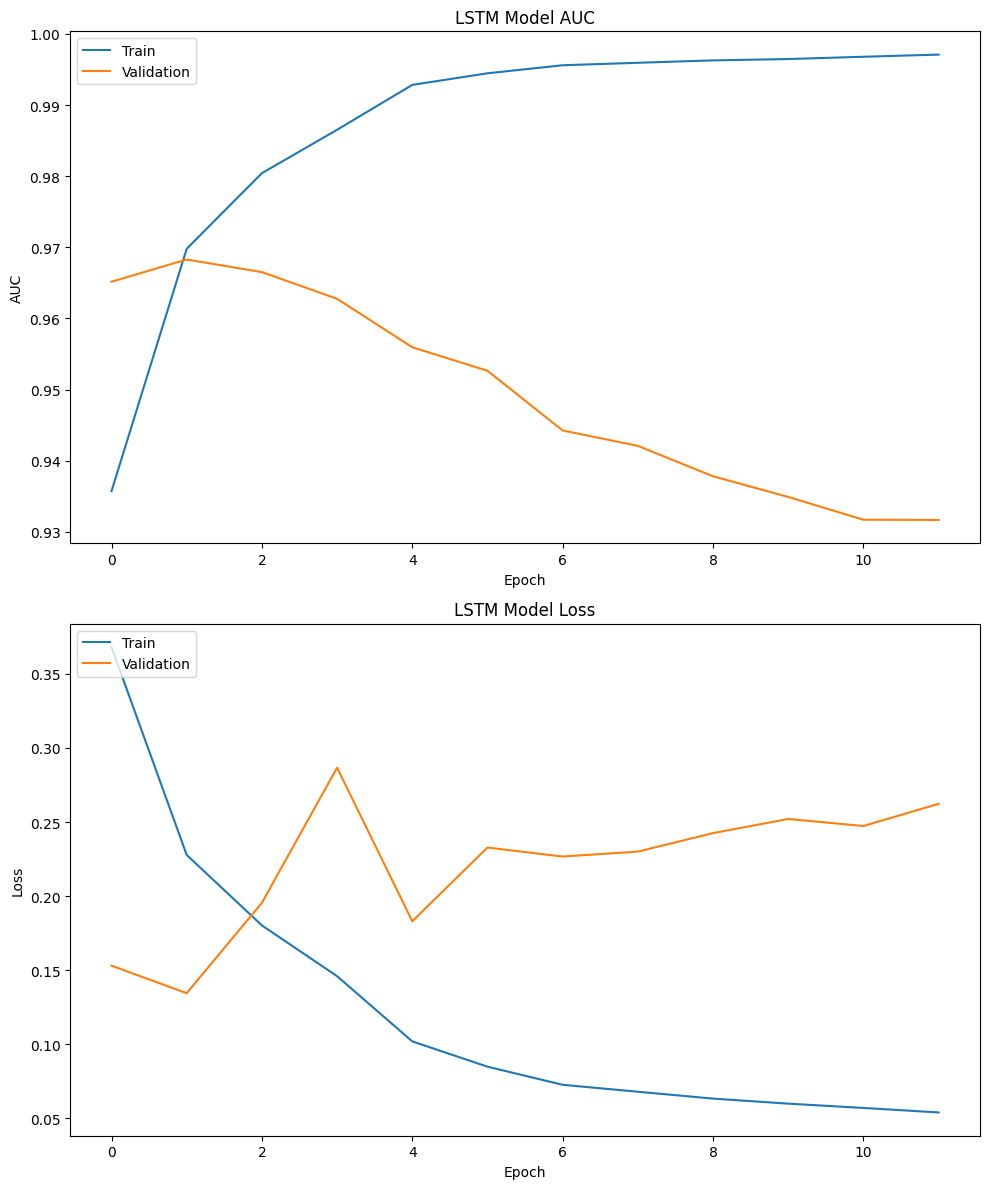

In [43]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot AUC
ax1.plot(history3.history['auc'])
ax1.plot(history3.history['val_auc'])
ax1.set_title('LSTM Model AUC')
ax1.set_ylabel('AUC')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
ax2.plot(history3.history['loss'])
ax2.plot(history3.history['val_loss'])
ax2.set_title('LSTM Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
import pickle

# After training the model...

# with open('my_model3.pkl', 'wb') as f:
#   pickle.dump(model_3, f)
# my_model3.save('my_model3.h5')

  # After training the model...

train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_auc = history3.history['auc']
val_auc = history3.history['val_auc']

with open('training_history3.pkl', 'wb') as f:
  pickle.dump({'train_loss': train_loss, 'val_loss': val_loss, 'train_auc': train_auc, 'val_auc': val_auc}, f)

In [45]:
import pickle

# After training the model...

# with open('my_model_3.pkl', 'wb') as f:
#   pickle.dump(model_3, f)

# Save model
model_3.save('../saved_models/model_03.h5')

# Load model
model_3 = load_model('../saved_models/model_03.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


it works better in terms of "Loss" rather than the second model


it shows decrease in Loss over epochs , but still illustrate the overfitting for the model and needs more try to have a better and acceptable result


# The 4th Model -  Bidirectional GRU

In [27]:
# Calculate class weights
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Class weights:", class_weight_dict)

# Define the model
embedding_dim = 50

text_input = Input(shape=(max_len,))
embedding = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm1 = Bidirectional(GRU(16, return_sequences=True))(embedding)
lstm2 = Bidirectional(GRU(8))(lstm1)
batch_norm1 = BatchNormalization()(lstm2)
dropout1 = Dropout(0.6)(batch_norm1)

feature_input = Input(shape=(additional_features_scaled.shape[1],))
feature_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.02))(feature_input)

concatenated = Concatenate()([dropout1, feature_dense])
dense1 = Dense(16, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
dropout2 = Dropout(0.6)(dense1)
output = Dense(1, activation='sigmoid')(dropout2)

model_4 = Model(inputs=[text_input, feature_input], outputs=output)

optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
model_4.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Record start time
start_time = time.time()

# Train the model
history4 = model_4.fit(
    [X_text_train, X_feat_train], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime)}")

Class weights: {0: 0.5532228169550832, 1: 5.197233523189585}
Epoch 1/50
3194/3194 [==============================] - ETA: 0s - loss: 0.5552 - auc: 0.8727
Epoch 1: val_auc improved from -inf to 0.95917, saving model to best_model.h5
3194/3194 [==============================] - 168s 50ms/step - loss: 0.5552 - auc: 0.8727 - val_loss: 1.2028 - val_auc: 0.9592 - lr: 5.0000e-04
Epoch 2/50
   1/3194 [..............................] - ETA: 2:04 - loss: 0.3916 - auc: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3193/3194 [============================>.] - ETA: 0s - loss: 0.3312 - auc: 0.9414
Epoch 2: val_auc improved from 0.95917 to 0.96395, saving model to best_model.h5
3194/3194 [==============================] - 116s 36ms/step - loss: 0.3311 - auc: 0.9414 - val_loss: 0.1872 - val_auc: 0.9640 - lr: 5.0000e-04
Epoch 3/50
3193/3194 [============================>.] - ETA: 0s - loss: 0.2970 - auc: 0.9525
Epoch 3: val_auc did not improve from 0.96395
3194/3194 [==============================] - 123s 39ms/step - loss: 0.2970 - auc: 0.9525 - val_loss: 1.6272 - val_auc: 0.9617 - lr: 5.0000e-04
Epoch 4/50
3193/3194 [============================>.] - ETA: 0s - loss: 0.2782 - auc: 0.9578
Epoch 4: val_auc did not improve from 0.96395
3194/3194 [==============================] - 111s 35ms/step - loss: 0.2782 - auc: 0.9579 - val_loss: 1.8969 - val_auc: 0.9573 - lr: 5.0000e-04
Epoch 5/50
3194/3194 [==============================] - ETA: 0s - loss: 0.2588 - auc: 0.9634
Epoch 5: val_auc did not improve from

In [28]:
# Evaluate the model
y_pred = model_4.predict([X_text_test, X_feat_test])
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc_score}")

999/999 [==============================] - 13s 11ms/step
Test AUC: 0.963676183927819


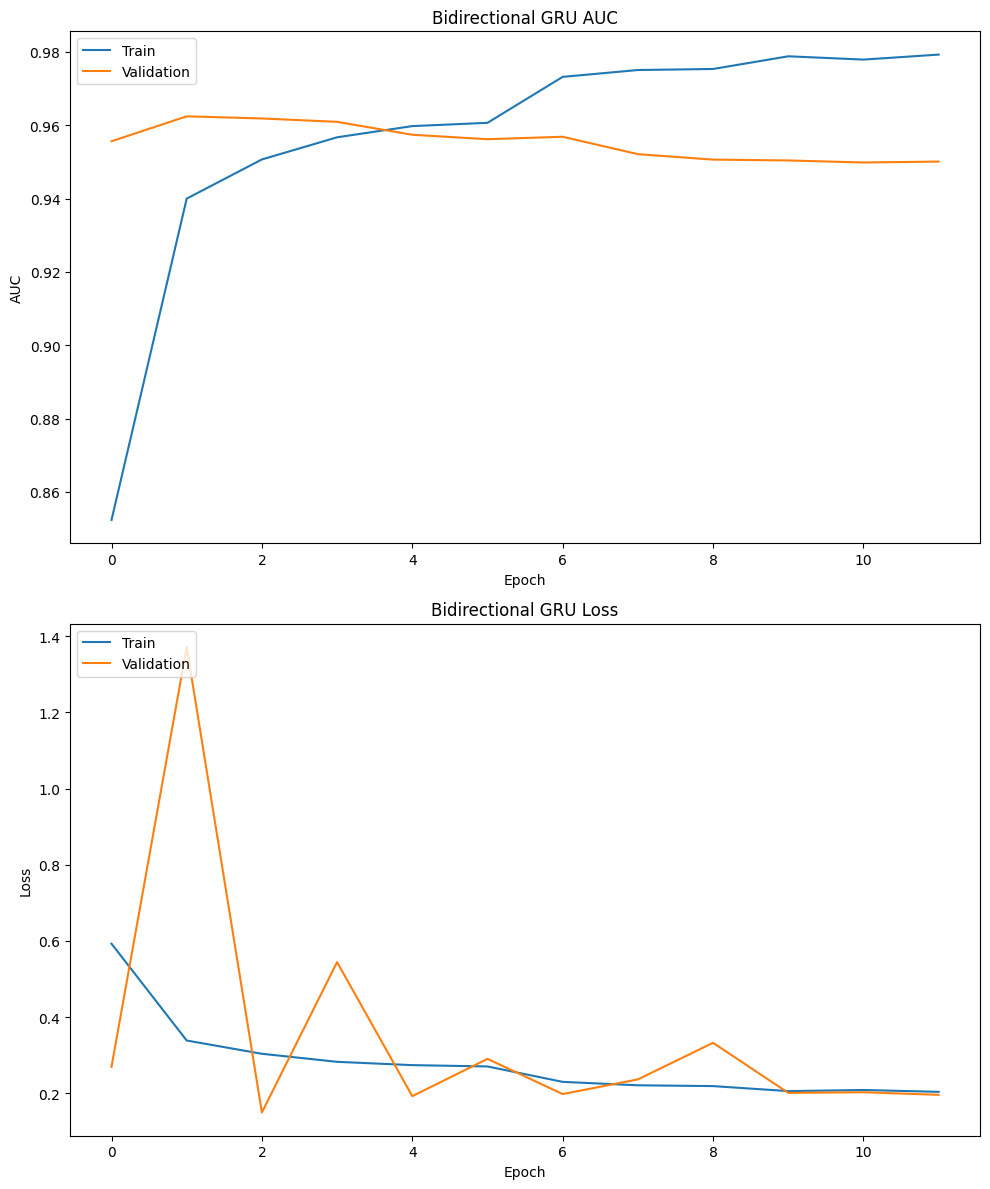

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot AUC
ax1.plot(history4.history['auc'])
ax1.plot(history4.history['val_auc'])
ax1.set_title('Bidirectional GRU AUC')
ax1.set_ylabel('AUC')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
ax2.plot(history4.history['loss'])
ax2.plot(history4.history['val_loss'])
ax2.set_title('Bidirectional GRU Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
import pickle

# After training the model...

with open('my_model.pkl', 'wb') as f:
  pickle.dump(model_4, f)



In [30]:
# After training the model...

train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
train_auc = history4.history['auc']
val_auc = history4.history['val_auc']

with open('training_history.pkl', 'wb') as f:
  pickle.dump({'train_loss': train_loss, 'val_loss': val_loss, 'train_auc': train_auc, 'val_auc': val_auc}, f)


In [ ]:
def preprocess_text(instance):
    # Tokenize and pad the instance
    instance_seq = tokenizer.texts_to_sequences([instance])
    instance_pad = pad_sequences(instance_seq, maxlen=max_len)

    # Create dummy additional features
    # Adjust the shape based on your actual additional features
    dummy_features = np.zeros((1, additional_features_scaled.shape[1]))

    return [instance_pad, dummy_features]
# Define a prediction function wrapper for LIME
def predict_with_preprocessing(texts):
    processed_inputs = [preprocess_text(text) for text in texts]
    text_inputs = np.array([inputs[0] for inputs in processed_inputs]).squeeze()
    feature_inputs = np.array([inputs[1] for inputs in processed_inputs]).squeeze()

    predictions = model_4.predict([text_inputs, feature_inputs])
    return np.hstack((1 - predictions, predictions))  # Adjust shape for LIME



# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

# Explain a single instance
idx = 157  #
instance = df['cleaned_text'][idx]
exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)

# Show explanation
exp.show_in_notebook(text=instance)

157/157 [==============================] - 2s 15ms/step


In [ ]:
# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

# Explain a single instance
idx = 1450  #
instance = df['cleaned_text'][idx]
exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)

# Show explanation
exp.show_in_notebook(text=instance)

157/157 [==============================] - 2s 14ms/step
